### Using SAM in combination with a pretrained Model trained for only detecting the text area

In [3]:
import os
import cv2
import sys
import onnx
import random

import torch
import numpy as np
import onnxruntime as ort
import torch.nn.functional as F
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from typing import List, Dict
from natsort import natsorted
from einops import rearrange
from IPython.display import Image as ShowImage

In [4]:
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 1024

In [5]:
def load_single_image(img_path: str) -> np.array:
    img = cv2.imread(img_path, 1)
    h, w, _ = img.shape
    img = cv2.resize(
        img,
        (IMAGE_WIDTH, IMAGE_HEIGHT),
    )
    img = img.astype(np.float32)
    img /= 255.0
    img = np.expand_dims(img, axis=0)
    img = np.transpose(img, axes=[0, 3, 1, 2])
    return img

Images: 8
0


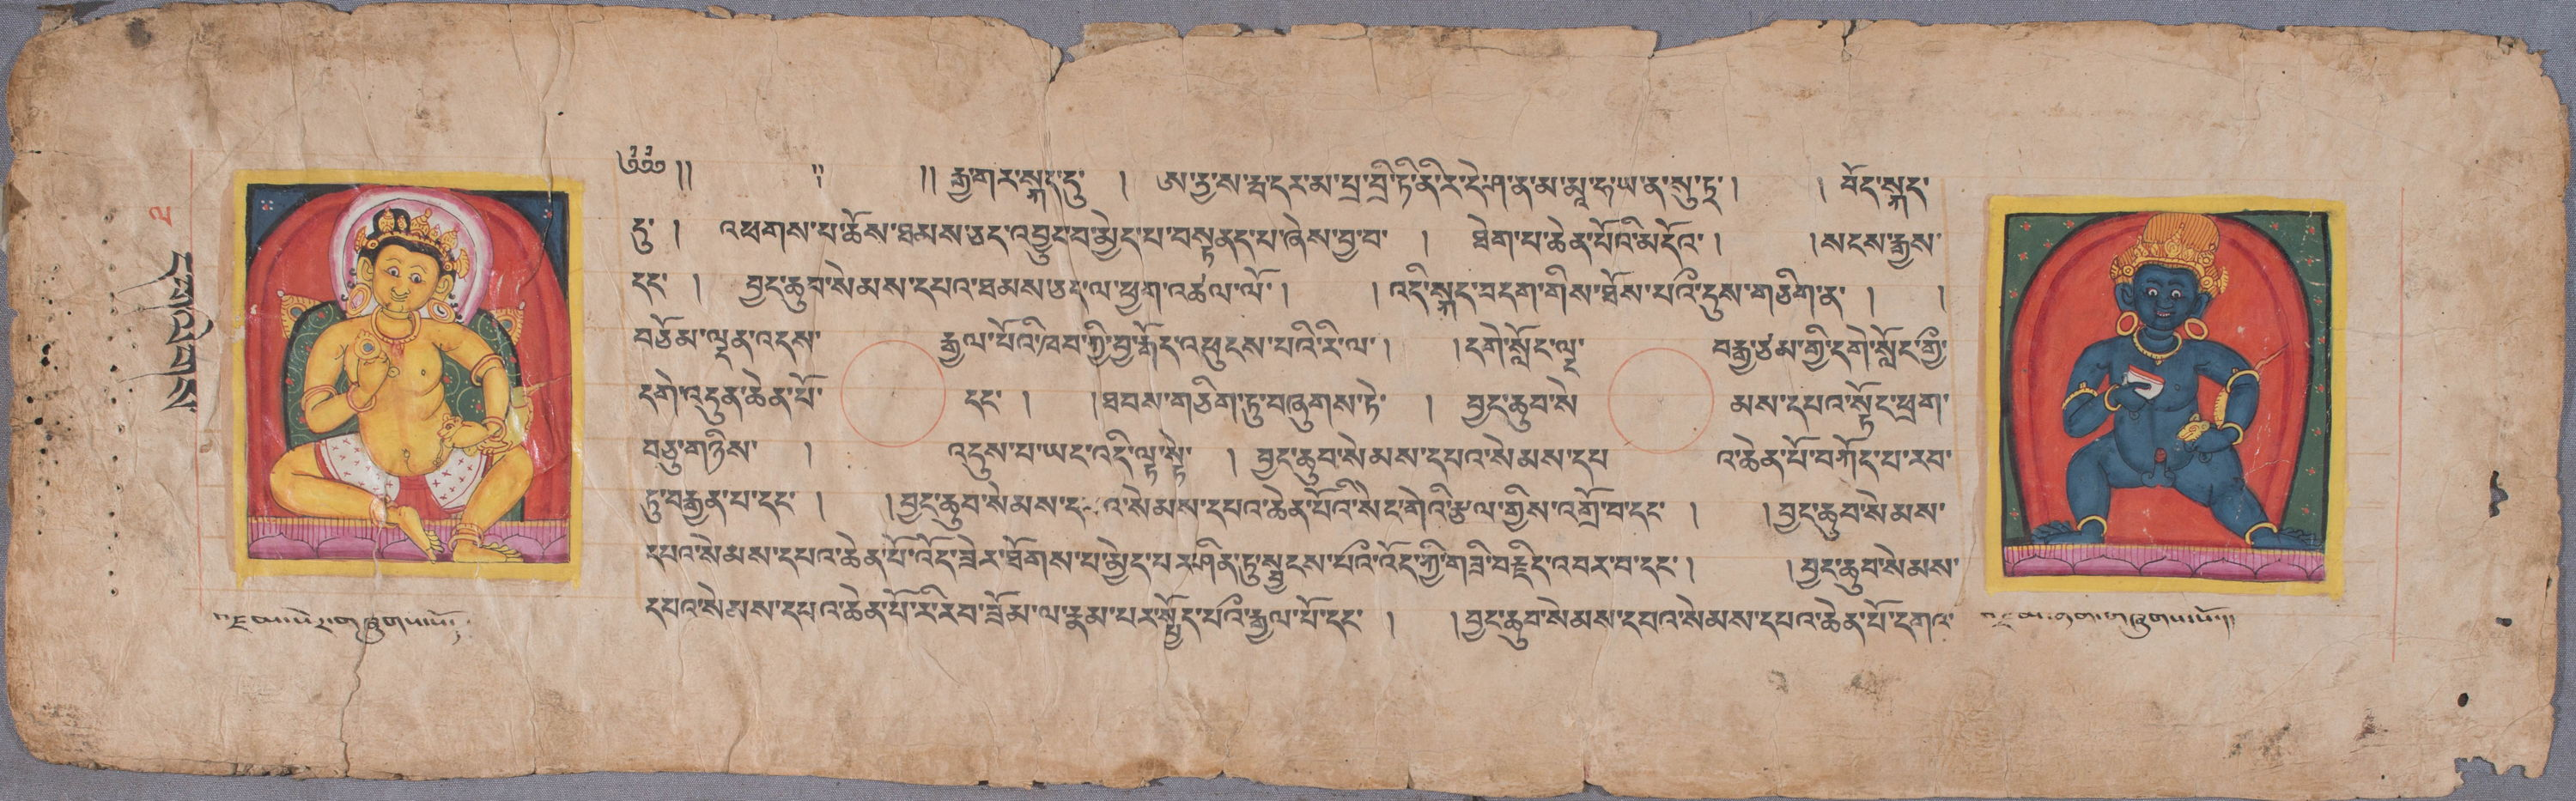

In [8]:
test_images = natsorted(glob("tmp/*.jpg"))
print(f"Images: {len(test_images)}")

rand_idx = random.randint(0, len(test_images)-1)
print(rand_idx)
ShowImage(test_images[rand_idx])

#### Using Network based on single resized Images

In [9]:
onnx_path = "OnnxModels\LA_TextArea_v1_quant.onnx"
ort_sess = ort.InferenceSession(onnx_path)

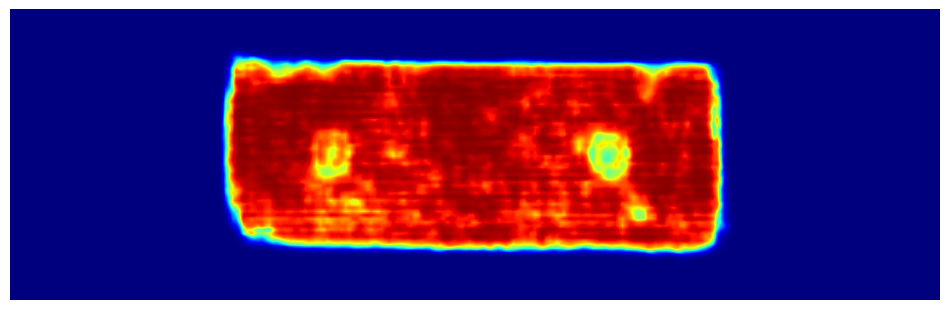

In [10]:
test_img = load_single_image(test_images[rand_idx])
outputs = ort_sess.run(None, {'input': test_img})
activated_outs = F.sigmoid(torch.from_numpy(outputs[0]))
activated_outs = torch.permute(activated_outs, dims=[0, 2, 3, 1])
activated_outs = torch.squeeze(activated_outs, dim=0)

plt.figure(figsize=(12, 4))
plt.axis('off')
plt.imshow(activated_outs, cmap="jet")

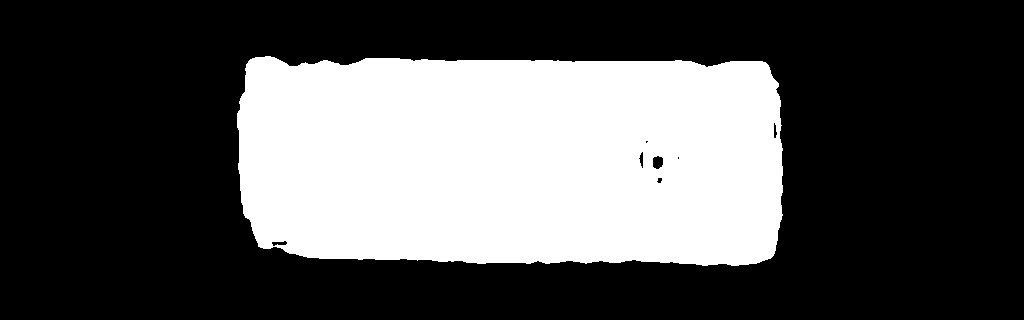

In [11]:
prob_threshold = 0.5
prediction = np.where(activated_outs > prob_threshold, 255, 0)
prediction = prediction.astype(np.uint8)
prediction = cv2.cvtColor(prediction, cv2.COLOR_GRAY2RGB)
display(Image.fromarray(prediction))

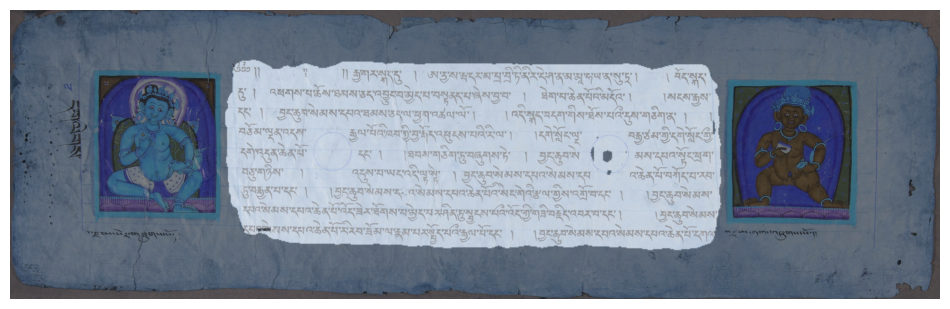

In [12]:
original_image = cv2.imread((test_images[rand_idx]))
prediction = prediction.astype(np.uint8)
output_single = cv2.resize(prediction, ((original_image.shape[1], original_image.shape[0])))

plt.figure(figsize=(12, 4))
plt.axis('off')
plt.imshow(original_image)
plt.imshow(output_single, cmap='jet', alpha=0.4)

#### Using Network based on pre-patched Training Data

In [13]:
def get_paddings(img: np.array, patch_size: int = 256) -> tuple[int, int, int, int]:
    y_pad = (img.shape[0] - (img.shape[0] % patch_size) + patch_size) - img.shape[0]
    x_pad = (img.shape[1] - (img.shape[1] % patch_size) + patch_size) - img.shape[1]

    if y_pad % 2 != 0:
        y_pad1 = int(y_pad / 2)
        y_pad2 = int(y_pad / 2 + 1)

    else:
        y_pad1 = int(y_pad / 2)
        y_pad2 = int(y_pad / 2)

    if x_pad % 2 != 0:
        x_pad1 = int(x_pad / 2)
        x_pad2 = int(x_pad / 2 + 1)

    else:
        x_pad1 = int(x_pad / 2)
        x_pad2 = int(x_pad / 2)

    return y_pad1, y_pad2, x_pad1, x_pad2


def pad_image(img: np.array, patch_size: int = 512, pad_value: int = 0) -> np.array:
    y_pad1, y_pad2, x_pad1, x_pad2 = get_paddings(img, patch_size=patch_size)
    padded_img = np.pad(
        img,
        pad_width=((y_pad1, y_pad2), (x_pad1, x_pad2), (0, 0)),
        mode="constant",
        constant_values=pad_value,
    )

    return padded_img


def patch_image(img: np.array, patch_size: int = 512) -> np.array:
    return rearrange(
        img,
        "(h dim1) (w dim2) c -> (h w) dim1 dim2 c",
        dim1=patch_size,
        dim2=patch_size,
    )
    

def load_image(img_path: str, binarize=False) -> np.array:
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img /= 255.0

    return img

In [14]:
test_img = load_image(test_images[rand_idx])
patch_size = 512
test_img = load_image(test_images[rand_idx])

padded_img = pad_image(test_img, patch_size=patch_size)
sliced_img = patch_image(padded_img, patch_size=patch_size)
sliced_img = np.transpose(sliced_img, axes=[0, 3, 1, 2])

In [15]:
onnx_path = "OnnxModels\TextArea_DeepLab_Patched512_q.onnx"
ort_sess = ort.InferenceSession(onnx_path)

In [16]:
outputs = ort_sess.run(None, {'input': sliced_img})
activated_outs = F.sigmoid(torch.from_numpy(outputs[0]))
activated_outs = torch.permute(activated_outs, dims=[0, 2, 3, 1])
activated_outs = torch.squeeze(activated_outs, dim=0)

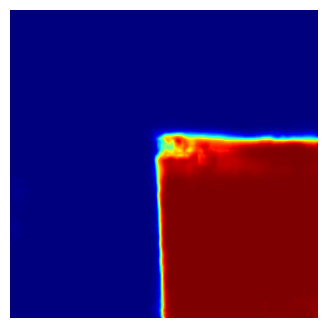

In [17]:
random_idx = random.randint(0, activated_outs.shape[-1])
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(activated_outs[random_idx], cmap="jet")

In [18]:
def recombine_outputs(outputs: torch.tensor, padded_img: np.array, patch_size: int = 512):
    """
    - recombines the output slices into an image of HxWxC of the padded_img
    - Inputs:
        - outputs: torch.tensor of shape B x H x W x C
        - padded_img: np.array of shape H x W x C
    """
    outputs = torch.squeeze(outputs, dim=-1)
    outputs = torch.permute(outputs, dims=[1, 2, 0])
    outputs = outputs.numpy()

    # are the numbers of returned slices * patchsize > padded_img.width ?
    if not outputs.shape[-1] * patch_size > padded_img.shape[1]:
        image_row = [outputs[:, :, x] for x in range(outputs.shape[-1])]
        combined_img = np.hstack((image_row))
    else:
        slice_index = outputs.shape[-1] // 2
        print(slice_index)
        outputs_up = outputs[:, :, :slice_index]
        upper_row = [outputs[:, :, x] for x in range(outputs_up.shape[-1])]
        lower_row = [outputs[:, :, x] for x in range(slice_index, outputs.shape[-1])]

        up_merged = np.hstack((upper_row))
        low_merged = np.hstack((lower_row))
        combined_img = np.vstack((up_merged, low_merged))

    return combined_img

6


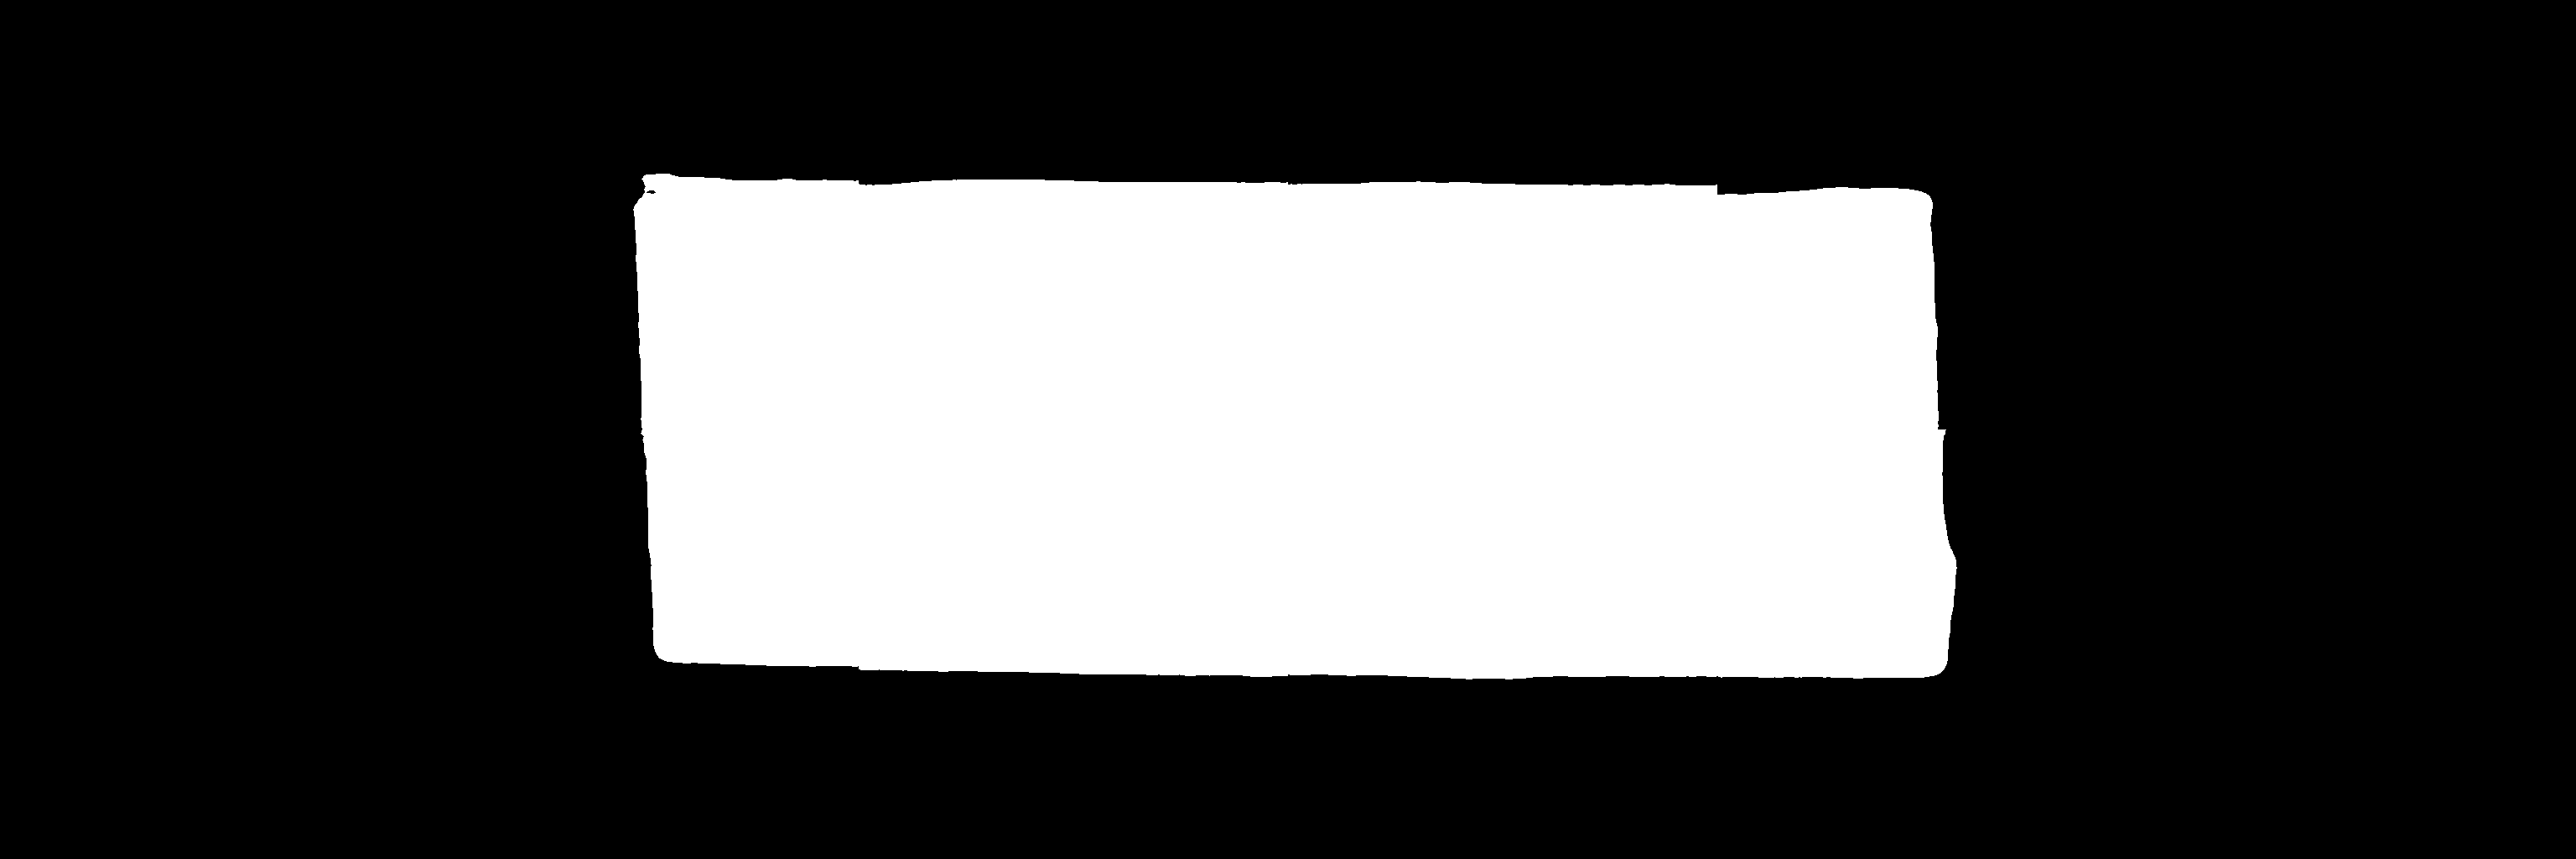

In [19]:
combined_img = recombine_outputs(activated_outs, padded_img, patch_size=512)
prob_threshold = 0.5
prediction = np.where(combined_img > prob_threshold, 255, 0)
prediction = prediction.astype(np.uint8)
prediction = cv2.cvtColor(prediction, cv2.COLOR_GRAY2RGB)
display(Image.fromarray(prediction))

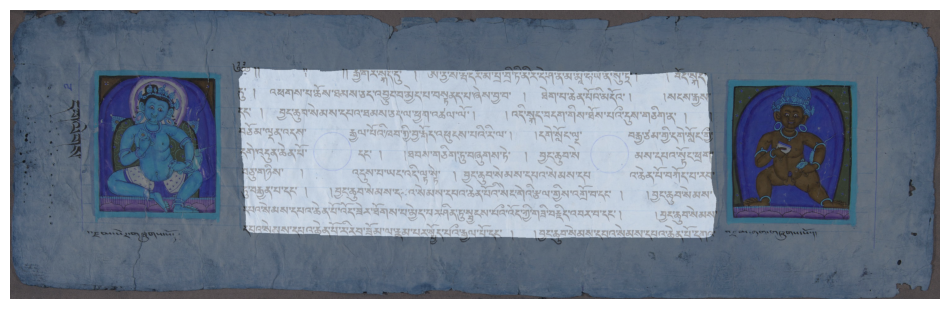

In [20]:
original_image = cv2.imread((test_images[rand_idx]))
prediction = prediction.astype(np.uint8)
output_patched = cv2.resize(prediction, ((original_image.shape[1], original_image.shape[0])))

plt.figure(figsize=(12, 4))
plt.axis('off')
plt.imshow(original_image)
plt.imshow(output_patched, cmap='jet', alpha=0.4)

### Use Predictions as Input for SAM

In [21]:
# choose input mask
#input_prediction = output_single
input_prediction = output_patched

#### 1. Use BBox Centers from Predicted mask als InputPoints for SAM

In [22]:
from segment_anything import sam_model_registry, SamPredictor

In [23]:
img_mask = cv2.cvtColor(input_prediction, cv2.COLOR_RGB2GRAY)
contours, _ = cv2.findContours(img_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
areas = [cv2.contourArea(x) for x in contours]

def filter_areas(x):
    area_threshold = (IMAGE_HEIGHT * IMAGE_WIDTH) * 0.001
    area = cv2.contourArea(x)
    if area > area_threshold:
        return area 


filtered_contours = list(filter(filter_areas, contours))

print(f"Total Contours: {len(contours)}, Filtered Contours: {len(filtered_contours)}")

Total Contours: 2, Filtered Contours: 1


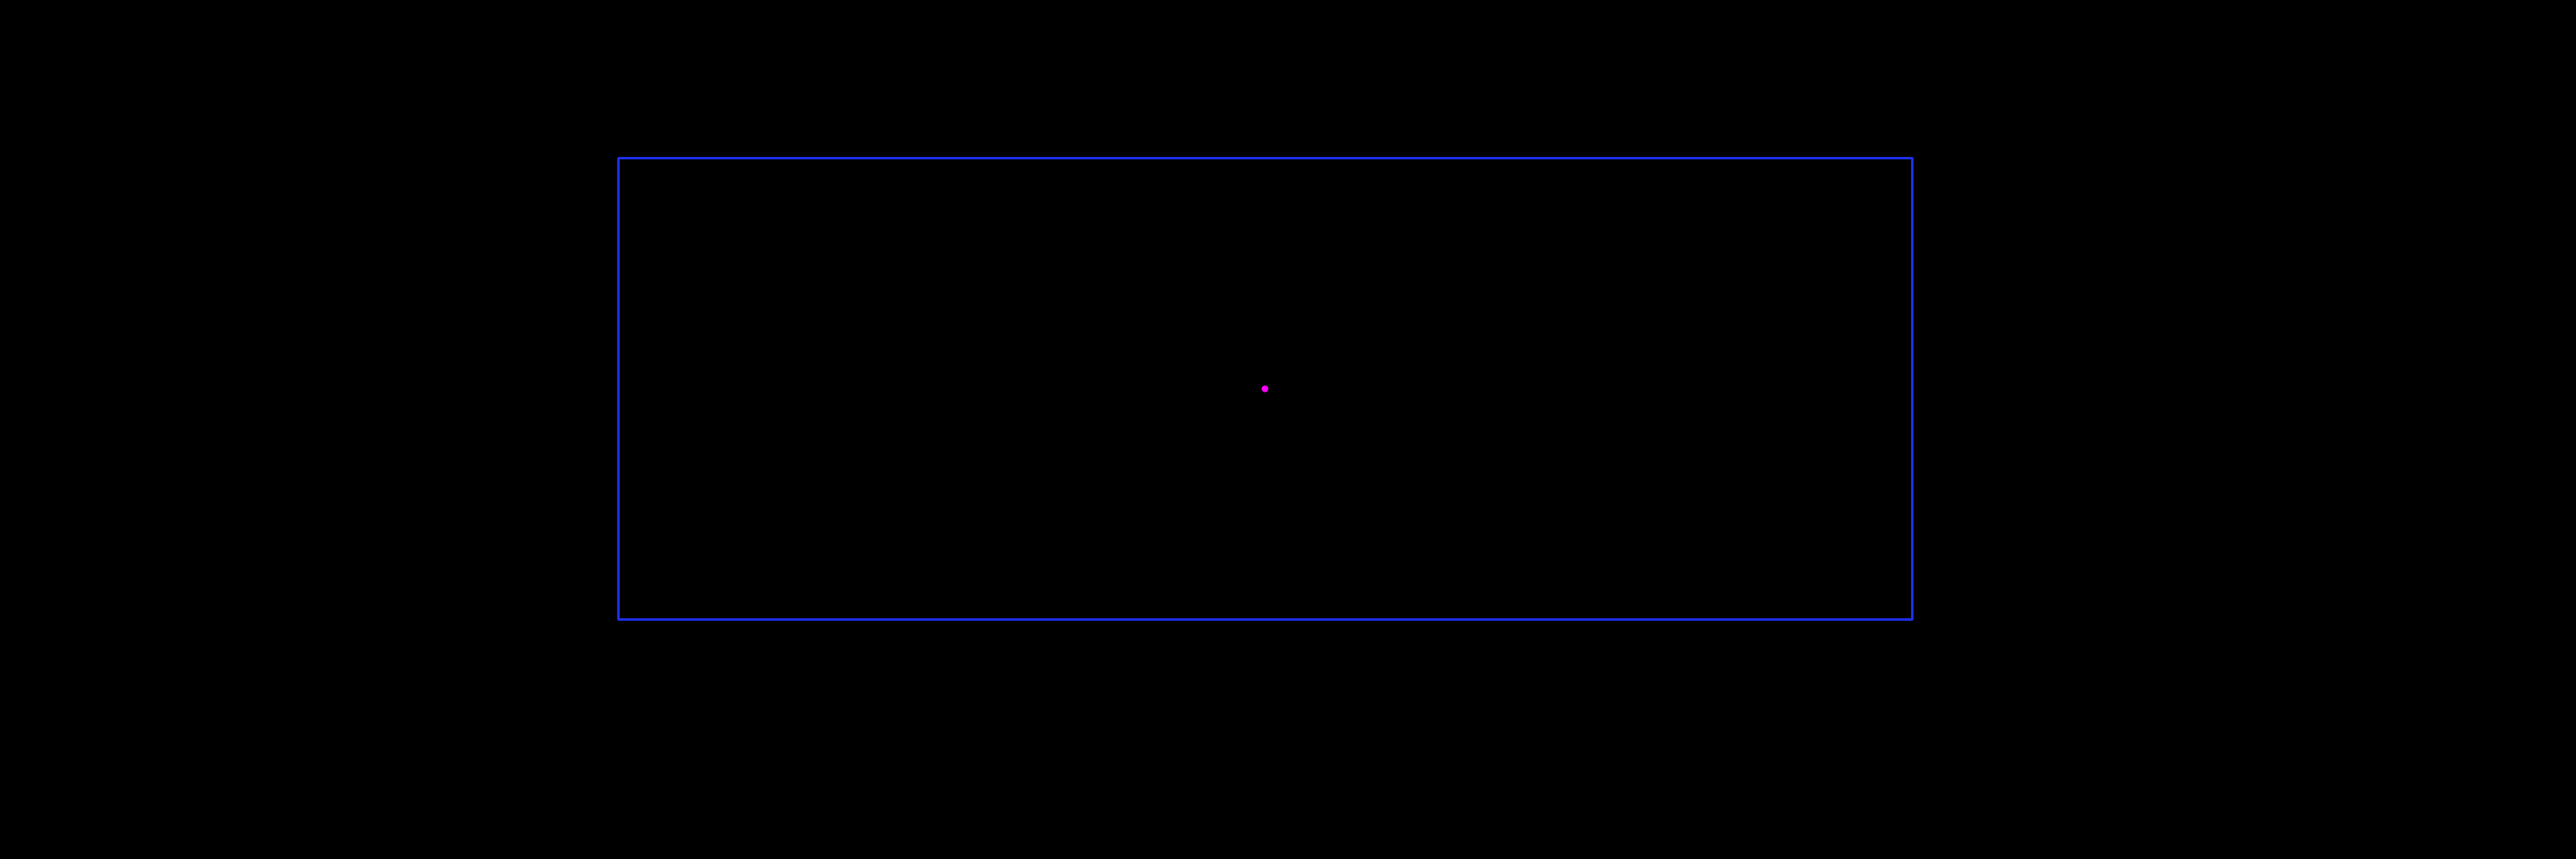

In [24]:
preview_bbox = np.zeros(shape=(prediction.shape), dtype=np.uint8)

input_points = []

for contour in filtered_contours:
    x,y,w,h = cv2.boundingRect(contour)
    
    center_point = [int(x+w/2), int(y+h/2)]
    input_points.append(center_point)
    
    random_color = [random.randint(0, 256) for x in range(3)]
    cv2.rectangle(preview_bbox,(x,y),(x+w,y+h), random_color, 2)
    cv2.circle(preview_bbox, center_point, radius=4, color=(255, 0, 255), thickness=-1)
    
display(Image.fromarray(preview_bbox))

In [25]:
input_points = np.array(input_points)
input_labels = np.ones(shape=(input_points.shape[0], ), dtype=np.uint8)

In [26]:
def init_sam(checkpoint: str, model_type: str) -> SamPredictor:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"using device: {device}")
    
    sam = sam_model_registry[model_type](checkpoint=checkpoint)

    if device == "cuda":
        torch.cuda.empty_cache()
    sam.to(device)
    predictor = SamPredictor(sam)

    return predictor

In [27]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam_predictor = init_sam(sam_checkpoint, model_type)

using device: cuda


In [28]:
"""
- https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
"""

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25) 

(1024, 3072, 3)

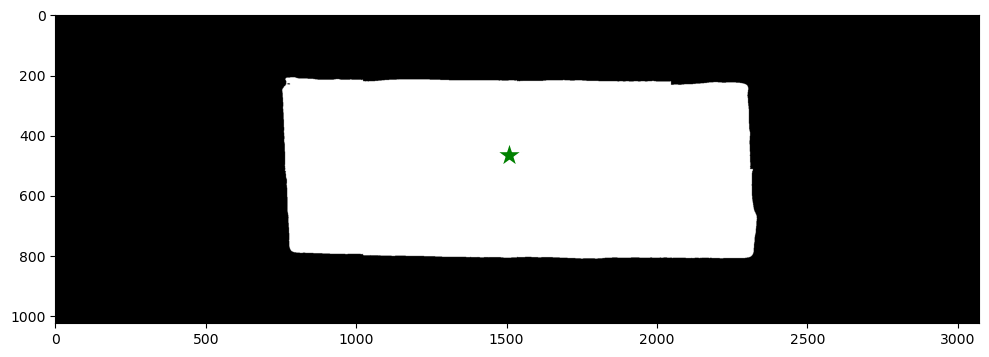

In [29]:
plt.figure(figsize=(12,4))
plt.imshow(prediction)
show_points(input_points, input_labels, plt.gca())
plt.axis('on')
plt.show()  

In [33]:
orig_image = cv2.imread(test_images[rand_idx])
orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
#orig_image = cv2.resize(orig_image, (IMAGE_WIDTH, IMAGE_HEIGHT))

sam_predictor.set_image(orig_image)

# using just the bbox center points
masks, scores, logits = sam_predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)

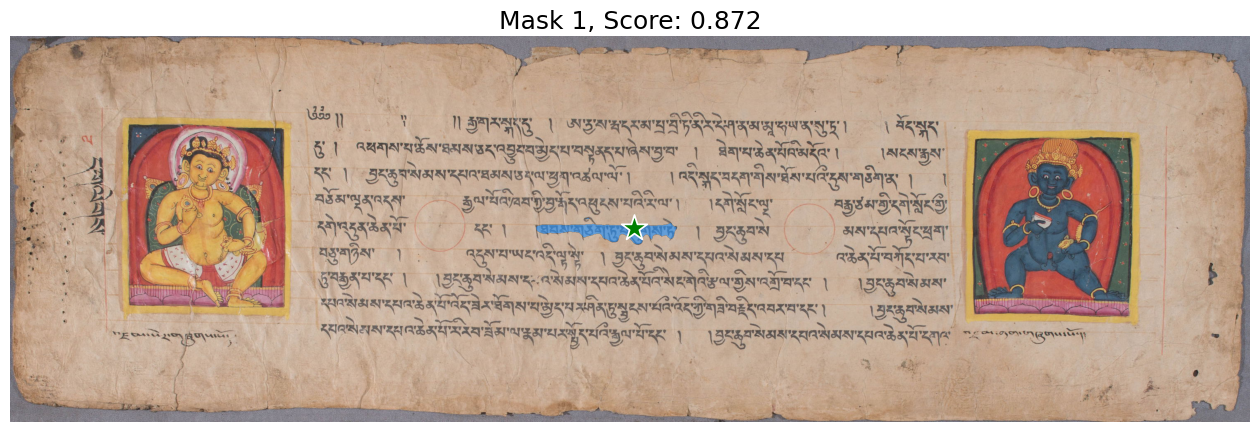

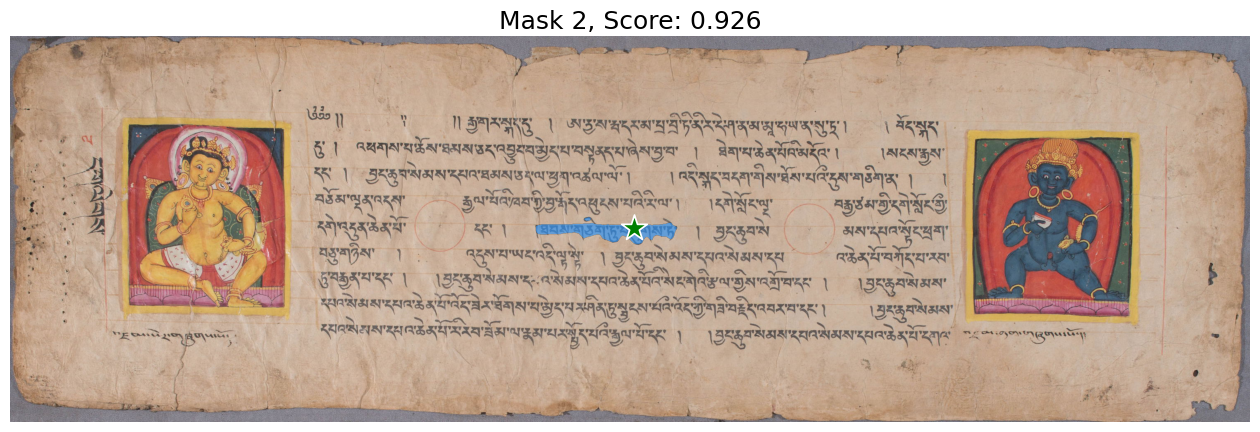

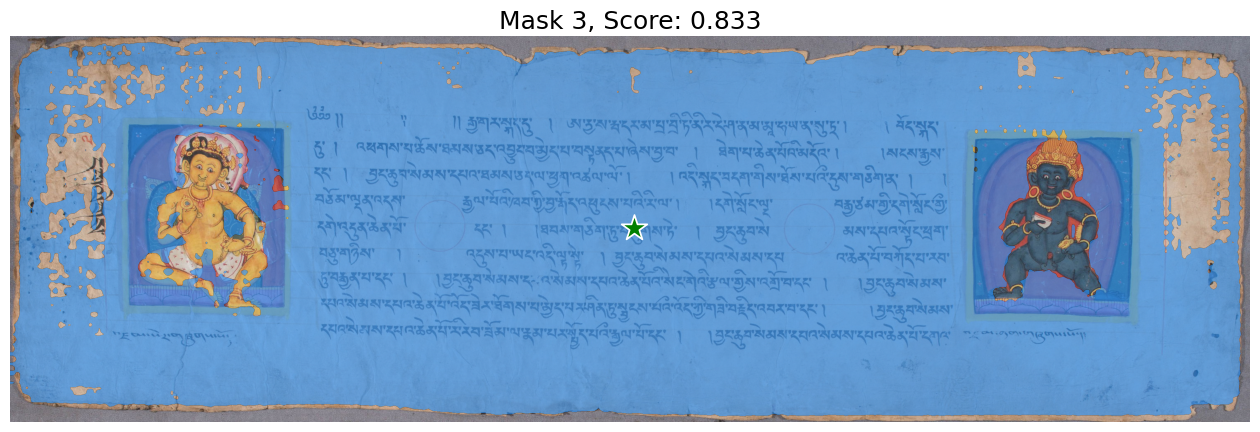

In [34]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(16,10))
    plt.imshow(orig_image)
    show_mask(mask, plt.gca())
    show_points(input_points, input_labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

#### 2. Use predicted mask from pretrained model in combination with guiding points

In [35]:
pred_mask = cv2.cvtColor(input_prediction, cv2.COLOR_RGB2GRAY)
pred_mask = cv2.resize(pred_mask, (256, 256)) # SAM needs this mask to be 256x256
pred_mask = np.expand_dims(pred_mask, axis=-1)
pred_mask = np.transpose(pred_mask, axes=[2, 0, 1])
print(pred_mask.shape)


(1, 256, 256)


In [36]:
masks, scores, logits = sam_predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    mask_input=pred_mask,
    multimask_output=True,
)

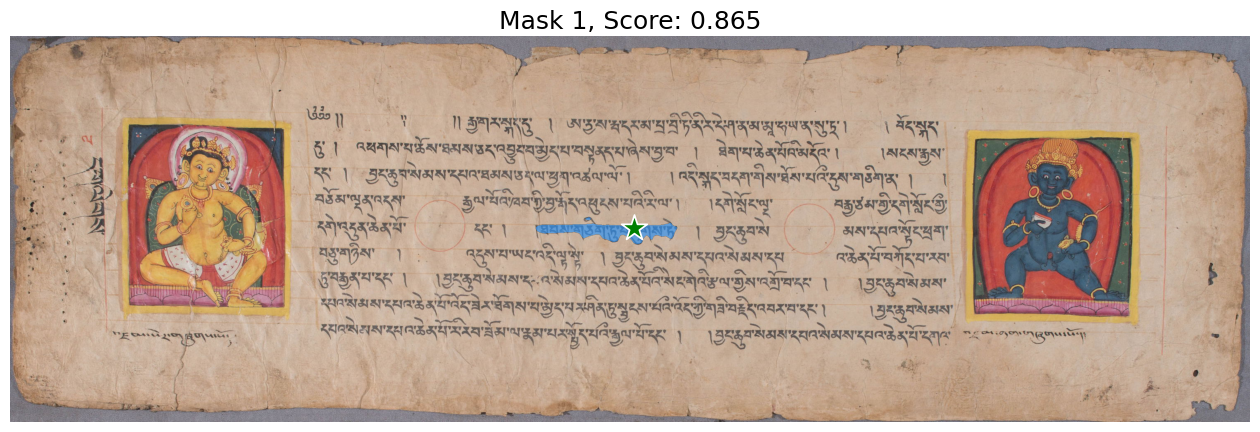

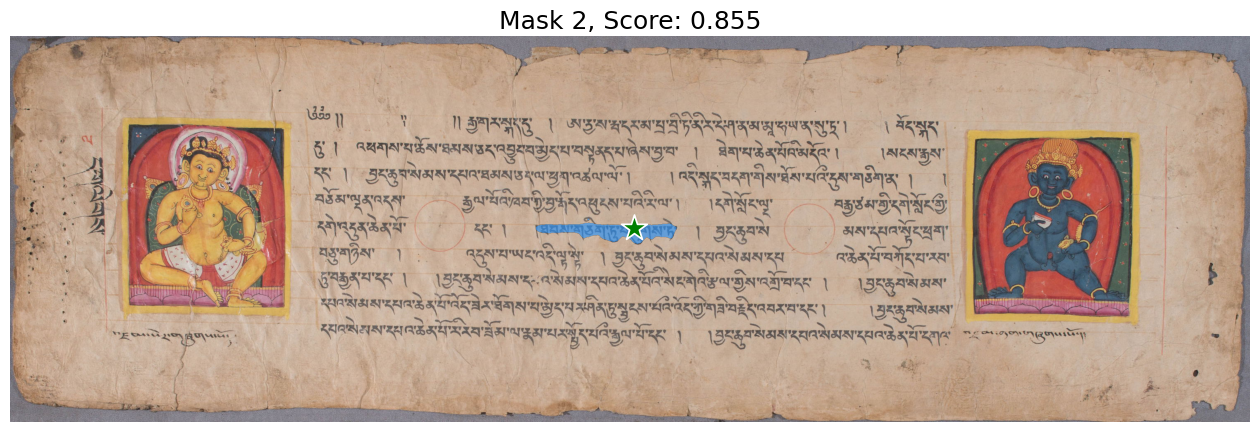

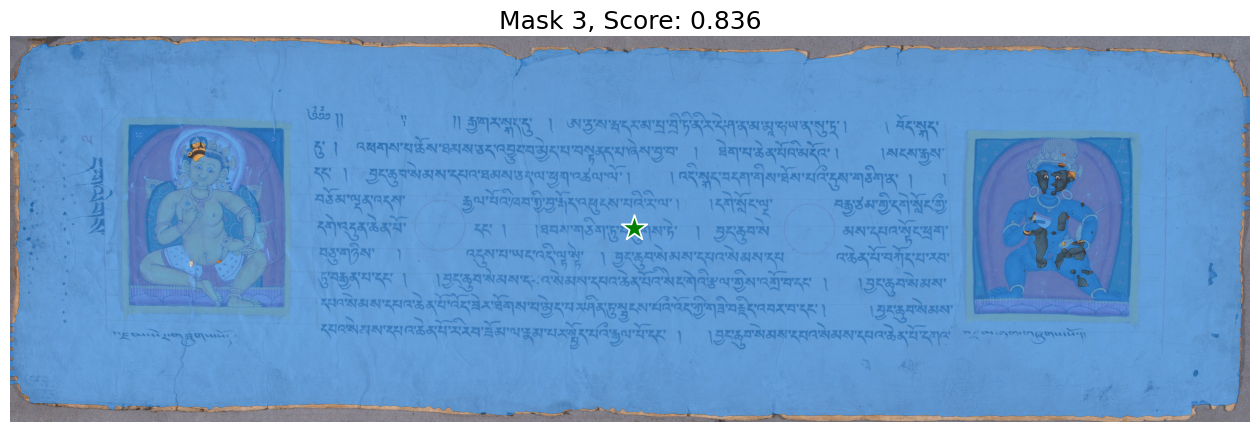

In [37]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(16,10))
    plt.imshow(orig_image)
    show_mask(mask, plt.gca())
    show_points(input_points, input_labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  